In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout ,SimpleRNN , Bidirectional
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
var='ETH'

In [2]:
df = pd.read_csv(f'Dataset/{var}-USD.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-02-16,2825.480713,2858.450439,2760.331055,2803.691406,2803.691406,17057114638
2024-02-17,2803.735840,2805.128662,2724.386963,2786.672607,2786.672607,17932379943
2024-02-18,2786.709717,2892.843506,2767.913086,2878.998047,2878.998047,23355830478
2024-02-19,2881.296875,2983.370605,2860.263672,2943.574707,2943.574707,15163110589
2024-02-20,2944.106445,3031.524414,2879.903320,3013.503662,3013.503662,20341598470


In [3]:
ma100 = df['Close'].rolling(100).mean()

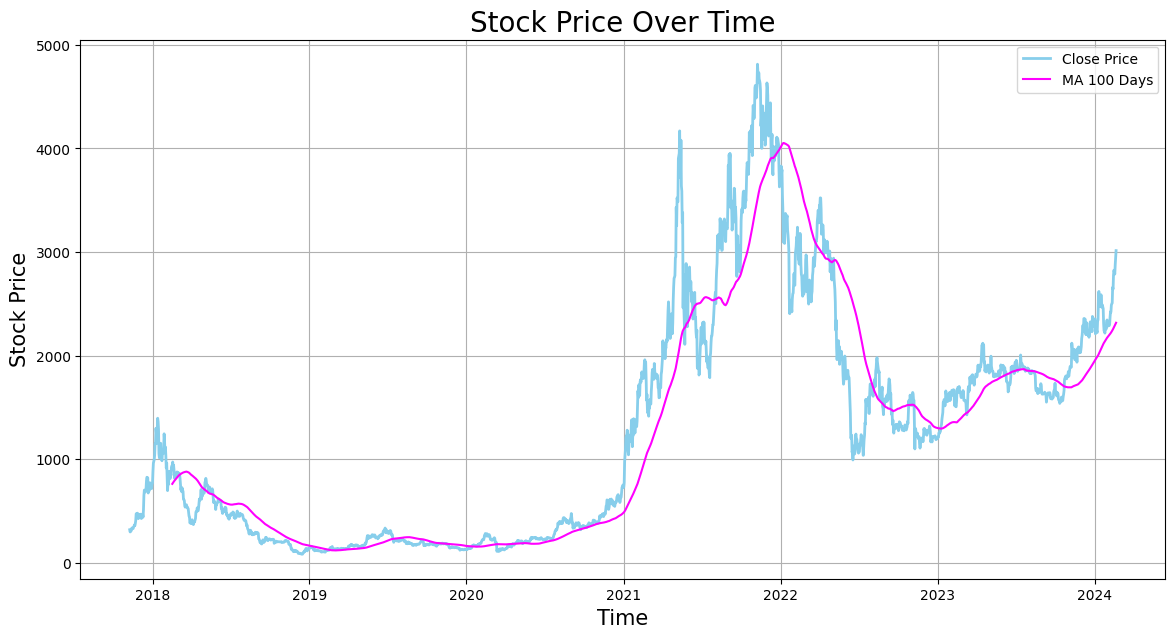

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))

plt.plot(df.index, df['Close'], color='skyblue', label='Close Price', linewidth=2)

plt.plot(ma100, color='magenta', label='MA 100 Days', linewidth=1.5)

plt.title('Stock Price Over Time', fontsize=20)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Stock Price', fontsize=15)

plt.legend()

plt.grid(True)


plt.show()

In [5]:
scaler = MinMaxScaler(feature_range=(-1, 1))
def create_dataset(df, window):
    scaled_data = scaler.fit_transform(df[['Close']])

    X = []
    y = []

    for i in range(window, len(scaled_data)):
        X.append(scaled_data[i-window:i])
        y.append(scaled_data[i])

    X, y = np.array(X), np.array(y)
    
    return X, y

In [6]:
def test_train_split(X,y):
    cv_size = int(0.2 * len(X))

    start_idx = np.random.randint(0, len(X) - cv_size)

    X_cv = X[start_idx:start_idx+cv_size]
    y_cv = y[start_idx:start_idx+cv_size]

    X_train = np.delete(X, np.s_[start_idx:start_idx+cv_size], axis=0)
    y_train = np.delete(y, np.s_[start_idx:start_idx+cv_size], axis=0)

    train_size = int(0.8 * len(X_train))
    X_train1, X_test = X_train[:train_size], X_train[train_size:]
    y_train1, y_test = y_train[:train_size], y_train[train_size:]

    return X_train1 , X_test , y_train1,y_test , X_cv,y_cv


In [7]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def metrics(y_test,pred,model):
    rmse = np.sqrt(mean_squared_error(y_test.reshape(-1,1),pred))
    r2 = r2_score(y_test.reshape(-1,1), pred)
    mae = mean_absolute_error(y_test.reshape(-1,1), pred)
    mape_score = mape(y_test.reshape(-1,1), pred)
    print(f"{model}\nrmse:{rmse}\nr2:{r2}\nmae:{mae}\nmape:{mape_score}\n\n")

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_predictions(predictions_, var):
    # Set the Seaborn theme
    sns.set_theme(style="darkgrid")

    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], color='red', label=f'Real {var} Price', linewidth=2.5)
    plt.plot(df.index[len(df) - len(predictions_):], predictions_, color='blue', label=f'Predicted {var} Price (LSTM)', linewidth=2.5)
    
    plt.title(f'{var} Price Prediction', fontsize=18)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel(f'{var} Price', fontsize=14)
    plt.legend(fontsize=12)
    
    # Optionally, use Seaborn's despine to remove the top and right spines
    sns.despine()

    plt.show()

## Base Model => RNN-BiLSTM

In [9]:
X, y = create_dataset(df, 3)
X_train1 , X_test,y_train1,y_test,X_cv,y_cv=test_train_split(X,y)

In [10]:
base_model=Sequential()
base_model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(3, 1)))
base_model.add(Bidirectional(LSTM(units=25, return_sequences=True)))
base_model.add(Bidirectional(LSTM(units=25)))
base_model.add(Dense(units=1))  

c:\Users\saket\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
optimizer = Adam(learning_rate=0.01)
base_model.compile(optimizer=optimizer, loss='mean_absolute_error')

In [12]:
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 3, 50)          │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 3, 50)          │        15,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 50)             │        15,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,051 (129.11 KB)

 Trainable params: 33,051 (129.11 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history_base_model = base_model.fit(X_train1, y_train1, epochs=100, batch_size=322,validation_data=(X_cv,y_cv))

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - loss: 0.5364 - val_loss: 0.1222
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2105 - val_loss: 0.2153
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1473 - val_loss: 0.0605
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1327 - val_loss: 0.1797
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0847 - val_loss: 0.0865
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0666 - val_loss: 0.0743
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0594 - val_loss: 0.1008
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0577 - val_loss: 0.0833
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0431 - val_loss: 0.0746
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0378 - val_loss: 0.0679
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0353 - val_loss: 0.0557
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0294 - val_l

In [14]:
base_model.save(f'base_model_{var}.h5')

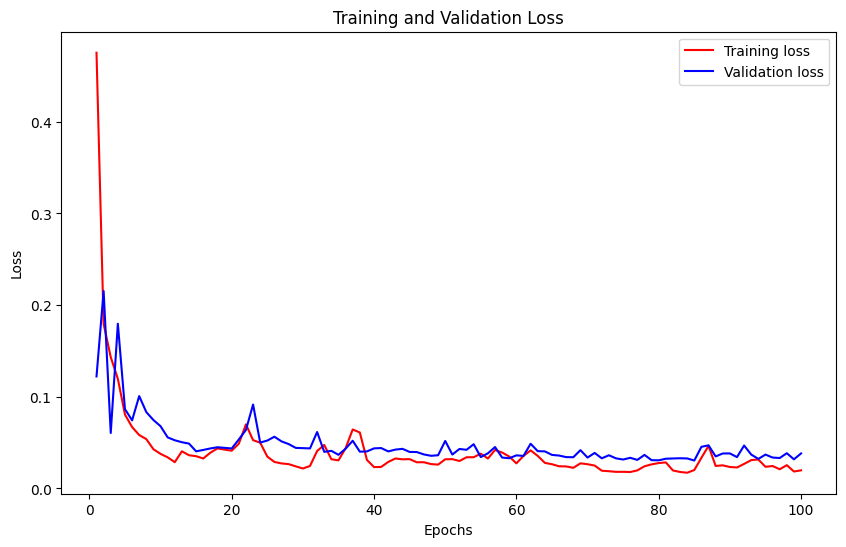

In [15]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by the 'fit' method
training_loss = history_base_model.history['loss']
validation_loss = history_base_model.history['val_loss']
epochs = range(1, len(training_loss) + 1)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'r', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss',)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
predictions = base_model.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions.reshape(-1,1))

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [17]:
metrics(scaler.inverse_transform(y_test),predictions_inverse,"Base Model Inverse Scaled Metrics")

Base Model Inverse Scaled Metrics
rmse:54.31015922776119
r2:0.9650825639404309
mae:37.673837747232625
mape:1.8982408474416




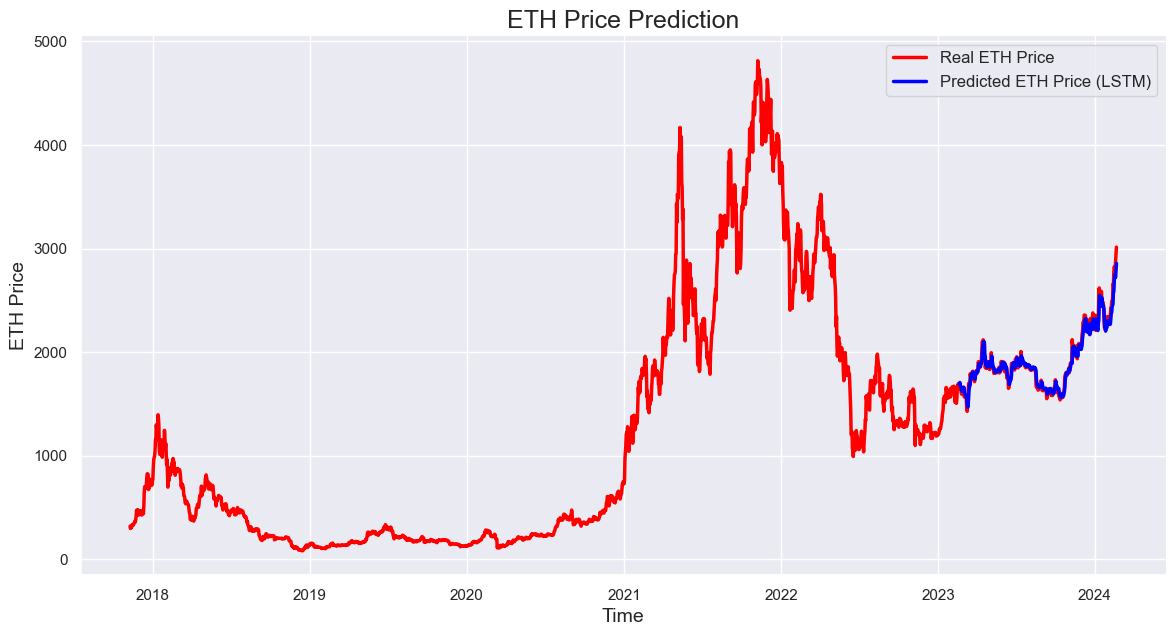

In [18]:
plot_predictions(predictions_inverse,var)

In [19]:
import tensorflow
df_test = pd.read_csv(f'Dataset/{var}-USD.csv')
base_model = tensorflow.keras.models.load_model(F"./base_model_{var}.h5")
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.set_index('Date', inplace=True)

In [20]:
scaled_data_test = scaler.transform(df_test[['Close']])

X_test_ = []
y_test_ = []

for i in range(3, len(scaled_data_test)):
    X_test_.append(scaled_data_test[i-3:i])
    y_test_.append(scaled_data_test[i])

X_test_, y_test_ = np.array(X_test_), np.array(y_test_)

In [21]:
predictions_test_1 = base_model.predict(X_test_)
predictions_test_1_ = scaler.inverse_transform(predictions_test_1.reshape(-1,1))

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [22]:
metrics(y_test_,predictions_test_1,"Base Model 2 (Testset2)")

Base Model 2 (Testset2)
rmse:0.03923275206776836
r2:0.9931456821444737
mae:0.02163366626996146
mape:15.098326438441168




In [23]:
metrics(scaler.inverse_transform(y_test_),predictions_test_1_,"Base Model 2 (Testset2) Inverse Scaled Data")

Base Model 2 (Testset2) Inverse Scaled Data
rmse:92.74189595318002
r2:0.9931456816707649
mae:51.13959679770457
mape:4.968678232888047




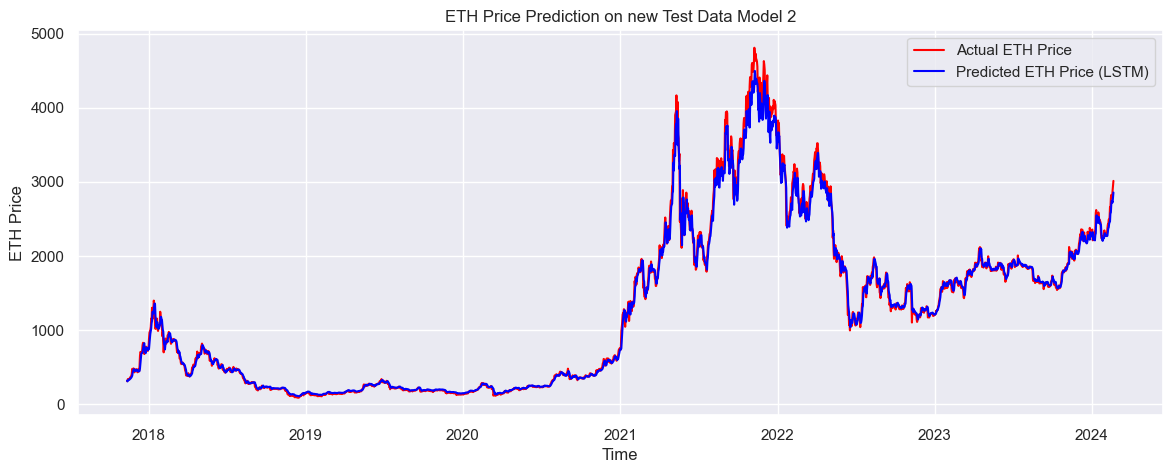

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,5))
plt.plot(df_test.index[3:],scaler.inverse_transform(y_test_.reshape(-1,1)), color = 'red', label = f'Actual {var} Price')
plt.plot(df_test.index[3:],predictions_test_1_, color = 'blue', label = f'Predicted {var} Price (LSTM)')
plt.title(f'{var} Price Prediction on new Test Data Model 2')
plt.xlabel('Time')
plt.ylabel(f'{var} Price')
plt.legend()